In [1]:
import numpy as np
import pandas as pd

from tqdm.contrib import tzip
from tqdm import tqdm 

import matplotlib.pyplot as plt

import igraph as ig

import seaserpent as ss
%env SEATABLE_TOKEN = 59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
%env SEATABLE_SERVER = https://flytable.mrc-lmb.cam.ac.uk/

env: SEATABLE_TOKEN=59481ea08c6a2ff4f3635ea54199520ce1a0f1dd
env: SEATABLE_SERVER=https://flytable.mrc-lmb.cam.ac.uk/


1. Load in Sven's connectivity per neuropil

In [2]:
df = pd.read_feather('syn_proof_analysis_filtered_520.feather')

2. Use _info_ to restrict df to only AL neurons

In [3]:
table = ss.Table(base='main', table='info').to_frame().reset_index()

In [4]:
df = df[df.syn_count>2]
df.pre_pt_root_id = df.pre_pt_root_id.astype(str)
df.post_pt_root_id = df.post_pt_root_id.astype(str)

In [23]:
table.fillna('NA', inplace=True)
#table=table[table.cell_type.str.contains('VM5d')]
alpns = table[table.cell_class.str.contains('ALPN')]
alrns = table[table.cell_type.str.contains('ORN')]
allns = table[table.cell_class.str.contains('ALLN')]

In [25]:
all_ids = list(alpns.root_id)+list(alrns.root_id)+list(allns.root_id)

In [26]:
al_df = df[np.logical_or(df.pre_pt_root_id.isin(all_ids), df.post_pt_root_id.isin(all_ids))][['pre_pt_root_id', 'post_pt_root_id', 'syn_count']]

3. Choose favorite PN Type

In [27]:
PN_TYPE='VM5D'

4. Calculate connection strength as input proprtion

In [28]:
tot_posts = al_df.groupby('post_pt_root_id').syn_count.sum()

In [29]:
syn_weights = pd.merge(al_df, tot_posts, left_on = 'post_pt_root_id', right_index =True)

In [30]:
syn_weights['syn_strength'] = syn_weights.syn_count_x / syn_weights.syn_count_y

In [31]:
syn_weights

,pre_pt_root_id,post_pt_root_id,syn_count_x,syn_count_y,syn_strength
8,720575940626202237,720575940624700140,4,8037,0.000498
5690,720575940604515808,720575940624700140,129,8037,0.016051
7253,720575940629540407,720575940624700140,527,8037,0.065572
10217,720575940631287912,720575940624700140,30,8037,0.003733
10587,720575940636000631,720575940624700140,313,8037,0.038945
...,...,...,...,...,...
12515793,720575940623303108,720575940618778247,3,3,1.000000
12517210,720575940617779284,720575940628175363,6,6,1.000000
12521371,720575940614457086,720575940627169673,3,3,1.000000
12527014,720575940614326162,720575940605162924,4,4,1.000000


5. Make graph using ratio in 4

In [32]:
col_names = [syn_weights.columns[x] for x in [0,1,-1]]

In [33]:
# g = ig.Graph.DataFrame(vm5d, directed=True)
tuples = [tuple(x) for x in syn_weights[col_names].values]
g = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['weight'])

6. Use igraph to get all neuron ids within 3 hops of an ALRN to a specific PN of your choice.

In [34]:
select_pn = table[table.cell_type.str.contains('VM5d')]
select_pn = select_pn[select_pn.cell_class.str.contains("ALPN")]
select_df = syn_weights[np.logical_or(syn_weights.pre_pt_root_id.isin(select_pn.root_id), syn_weights.post_pt_root_id.isin(select_pn.root_id))]

In [41]:
pn_names = select_pn.root_id
v_names = np.asarray(g.vs()['name'])
v_name = v_names[3]
v_val = np.argwhere(v_names == v_name)[0][0]

In [42]:
alrn_names = np.asarray(alrns.root_id)
alrn_vals = pd.Series(v_names).isin(alrn_names)
alrn_vals = alrn_vals[alrn_vals].index

In [43]:
g.neighborhood_size(v_val, 3)

15257

In [44]:
dists = np.asarray(g.distances(v_val, alrn_vals))
dists = dists[dists!=np.inf]

(array([1179.,  587.,  229.,    6.]),
 array([1.  , 1.75, 2.5 , 3.25, 4.  ]),
 <BarContainer object of 4 artists>)

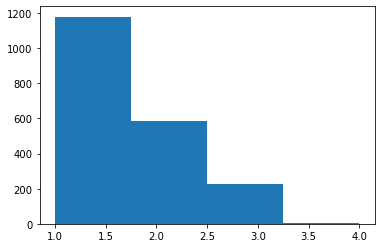

In [47]:
plt.hist(dists, bins=4)

In [48]:
pn_names

3562     720575940644961588
6723     720575940629279544
7803     720575940616020795
10854    720575940635082871
15050    720575940606649865
45455    720575940627035388
56830    720575940634325087
57996    720575940639121571
58142    720575940611372714
Name: root_id, dtype: object

In [49]:
alrn_to_pn = []
for pn in pn_names:
    curr_paths = g.get_all_simple_paths(pn, alrn_vals, cutoff=3, mode='in')
    alrn_to_pn += ([x[::-1] for x in curr_paths if pn not in x[1:]])


In [50]:
dists = [len(x) for x in alrn_to_pn]

In [51]:
xd = dict({1:[], 2:[], 3:[], 4:[]})
v_names_series = pd.Series(v_names)
for d, v in tzip(dists, alrn_to_pn):
    ratios = []
    for n,i in enumerate(v[1:]):
        #by_posts = syn_weights[syn_weights.post_pt_root_id == str(i)]
        #by_pres = by_posts[by_posts.pre_pt_root_id==str(post_names[n])]
        ratios.append(g.es()[g.get_eid(v[n], i, directed=True, error=True)]['weight'])
    xd[d].append(np.prod(ratios))


  0%|          | 0/5786545 [00:00<?, ?it/s]

In [52]:
[len(xd[i]) for i in [1,2,3,4]]

[0, 592, 47751, 5738202]

592
green
47751
blue
5738202
pink


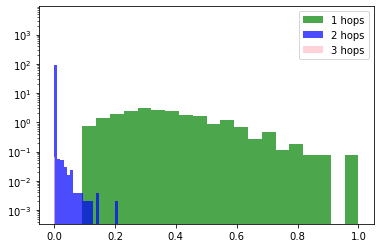

In [53]:
cols=['red', 'green', 'blue', 'pink']
maxer = np.max([np.max(xd[x]) for x in [2,3,4]])
for i in [2,3,4]:
    print(len(xd[i]))
    print(cols[i-1])
    plt.hist(xd[i]/maxer, color=cols[i-1], label=str(i-1)+" hops", bins=20, density=True, log=True, alpha=.7)
plt.legend()
plt.show()

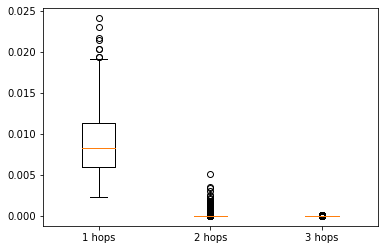

In [54]:
# cols=['red', 'green', 'blue', 'pink']
# maxer = np.max([np.max(xd[x]) for x in [2,3,4]])
# for i in [2,3,4]:
#     print(len(xd[i]))
#     print(cols[i-1])
#     plt.boxplot()
# plt.legend()
# plt.show()
plt.boxplot([xd[2], xd[3], xd[4]], labels=[str(x-1)+" hops" for x in [2,3,4]])
plt.show()

In [55]:
alrn_by_pn = []
for pn in pn_names:
    curr_paths = g.get_all_simple_paths(pn, alrn_vals, cutoff=3, mode='in')
    alrn_by_pn.append([x[::-1] for x in curr_paths if pn not in x[1:]])


In [56]:
sums = []
for alpn in tqdm(alrn_by_pn): #loop through the 9 row matrix
    flunk = []
    for p in alpn: #loop through each path within all path of the pns
        ratios = []
        for n,i in enumerate(p[1:]):
            ratios.append(g.es()[g.get_eid(p[n], i, directed=True, error=True)]['weight'])
        flunk.append(np.prod(ratios))
    sums.append(sum(flunk))


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:10<00:00,  7.87s/it]


In [57]:
sums

[0.9123119769149979,
 0.9126695858199431,
 0.9417961100032325,
 0.8758125278791459,
 0.8659154771316941,
 0.9472184271105334,
 0.8853270808802153,
 0.9207211930843343,
 0.9268705104191401]